In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
import ptitprince as pt
import re #I import this library 'cause I need to deal with regular expressions
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures

In [2]:
mergedDataBaseFile="Merged_DB.csv"
merged=pd.read_csv(mergedDataBaseFile)

In [3]:
merged['has_transitions'].dtype

dtype('bool')

In [4]:
merged

,id_band,score,has_transitions,albumCount,review_count
0,11143,0.500000,True,1.0,1
1,14768,0.770000,True,1.0,1
2,16693,0.860000,True,2.0,1
3,16950,0.783333,True,1.0,1
4,20572,0.550000,True,3.0,1
...,...,...,...,...,...
8090,51016,0.700000,True,1.0,4
8091,56642,0.700000,True,1.0,4
8092,60904,0.680000,False,1.0,6
8093,40786,0.680000,False,1.0,6


# Con el objetivo de empezar a responder preguntas acerca del estudio de las puntuaciones críticas obtenidas por las bandas en función de los features 
"tiene transciones" (has_transitions) el cual da cuenta de si la banda cambio de género entre el death metal y otros géneros, "conteo de discos" (albumCount) y conteo de reseñas (review_count), procedo como primer paso a estudiar la forma de la distrubución de los datos primero en términos de la variable booleana

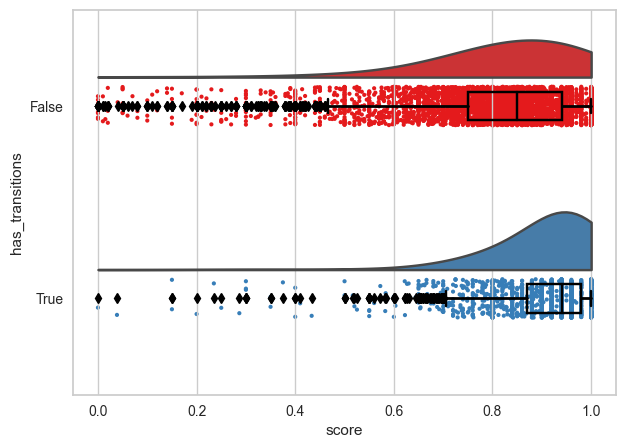

In [5]:
transitionsDF=merged[['has_transitions','score']]

f, ax=plt.subplots(figsize=(7,5))
dy="has_transitions"; dx="score"; ort="h";pal="Set1"

ax=pt.half_violinplot(x=dx,y=dy,data=transitionsDF,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data = transitionsDF, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = transitionsDF, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

In [6]:
TrueMean=transitionsDF.loc[transitionsDF['has_transitions']==True]['score'].mean()
TrueMode=transitionsDF.loc[transitionsDF['has_transitions']==True]['score'].mode().iloc[0]
FalseMean=transitionsDF.loc[transitionsDF['has_transitions']==False]['score'].mean()
FalseMode=transitionsDF.loc[transitionsDF['has_transitions']==False]['score'].mode().iloc[0]
print(f"la media de transiciones verdaderas es {TrueMean} y la moda es {TrueMode} y en el caso de las transciones en falso la meddia es {FalseMean} y la moda es {FalseMode}")

la media de transiciones verdaderas es 0.9041948579387051 y la moda es 1.0 y en el caso de las transciones en falso la meddia es 0.824935069147989 y la moda es 1.0


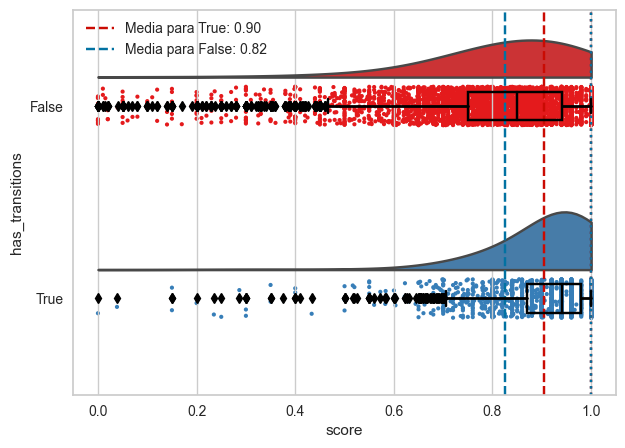

In [7]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=transitionsDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=transitionsDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=transitionsDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)

# Media
mean_value = transitionsDF[dx].mean()
ax.axvline(TrueMean, color='r', linestyle='--', label=f'Media para True: {TrueMean:.2f}')
ax.axvline(FalseMean, color='b', linestyle='--', label=f'Media para False: {FalseMean:.2f}')
# Moda
mode_value = transitionsDF[dx].mode().iloc[0]
ax.axvline(TrueMode, color='r', linestyle=':')
ax.axvline(FalseMode, color='b', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')

plt.show()


In [8]:
def outliersFilter(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    df[col] = df[col].where(~filtro, np.nan)
    mode = df[col].mode()[0]
    df[col].fillna(mode, inplace=True)
    return df

In [9]:
outliersFilter(merged,'score')

,id_band,score,has_transitions,albumCount,review_count
0,11143,1.000000,True,1.0,1
1,14768,0.770000,True,1.0,1
2,16693,0.860000,True,2.0,1
3,16950,0.783333,True,1.0,1
4,20572,0.550000,True,3.0,1
...,...,...,...,...,...
8090,51016,0.700000,True,1.0,4
8091,56642,0.700000,True,1.0,4
8092,60904,0.680000,False,1.0,6
8093,40786,0.680000,False,1.0,6


In [10]:
noOutliersDF=merged[['has_transitions','score']]
FilterTrueMean=noOutliersDF.loc[noOutliersDF['has_transitions']==True]['score'].mean()
FilterTrueMode=noOutliersDF.loc[noOutliersDF['has_transitions']==True]['score'].mode().iloc[0]
FilterFalseMean=noOutliersDF.loc[noOutliersDF['has_transitions']==False]['score'].mean()
FilterFalseMode=noOutliersDF.loc[noOutliersDF['has_transitions']==False]['score'].mode().iloc[0]
print(f"la media de transiciones verdaderas es {FilterTrueMean} y la moda es {FilterTrueMode} y en el caso de las transciones en falso la meddia es {FilterFalseMean} y la moda es {FilterFalseMode}")

la media de transiciones verdaderas es 0.9127633973235711 y la moda es 1.0 y en el caso de las transciones en falso la meddia es 0.8542869601643976 y la moda es 1.0


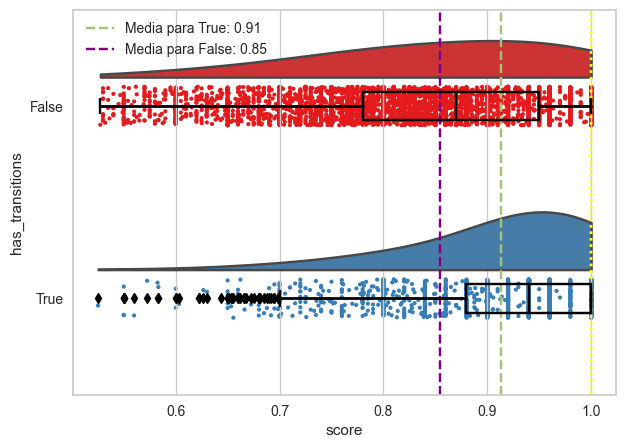

In [17]:
f, ax = plt.subplots(figsize=(7,5))
dy = "has_transitions"; dx = "score"; ort = "h"; pal = "Set1"

ax = pt.half_violinplot(x=dx, y=dy, data=noOutliersDF, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort)
ax = sns.stripplot(x=dx, y=dy, data=noOutliersDF, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort)
ax = sns.boxplot(x=dx, y=dy, data=noOutliersDF, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops={'linewidth':2, "zorder":10}, saturation=1, orient=ort)


ax.axvline(FilterTrueMean, color='g', linestyle='--', label=f'Media para True: {FilterTrueMean:.2f}')
ax.axvline(FilterFalseMean, color='purple', linestyle='--', label=f'Media para False: {FilterFalseMean:.2f}')

ax.axvline(FilterTrueMode, color='yellow', linestyle=':')
ax.axvline(FilterFalseMode, color='yellow', linestyle=':')

# Mostrar leyenda
ax.legend(loc='upper left')

plt.show()

# Con el objetivo de hacer un one hot encoding con la columna del booleano "has transitions" y aprovechando su caracter booleano solo cambio el tipo de dato a entero, de manera que los True se vuelven 1

In [12]:
merged['has_transitions']=merged['has_transitions'].astype(int)

In [13]:
merged

,id_band,score,has_transitions,albumCount,review_count
0,11143,1.000000,1,1.0,1
1,14768,0.770000,1,1.0,1
2,16693,0.860000,1,2.0,1
3,16950,0.783333,1,1.0,1
4,20572,0.550000,1,3.0,1
...,...,...,...,...,...
8090,51016,0.700000,1,1.0,4
8091,56642,0.700000,1,1.0,4
8092,60904,0.680000,0,1.0,6
8093,40786,0.680000,0,1.0,6


In [14]:
merged['albumCount'].max()

17.0